In [ ]:
# demo: loads file with all messages (CSTARTTIME, CSENDERENDPOINTID, ymdhm )
# show some charts, anomaly detection with LSTM autoencoders

In [1]:
import dfBasics
import common
import encoder
import pfAdapt
import charts
import anomaly

import pandas as pd
from pyspark.sql import functions

Setup Complete
Setup Complete


In [37]:
sparkSession = dfBasics.getSparkSession()
#df = sparkSession.read.parquet('hdfs://172.30.17.145:8020/user/admin/sla/CSENDERENDPOINTID/CSENDERENDPOINTID_9.parquet')
#df = sparkSession.read.parquet('hdfs://172.30.17.145:8020/user/admin/sla/sla_1580137124017.parquet')
#df = sparkSession.read.parquet('hdfs://172.30.17.145:8020/user/admin/sla/sla_1616754087742.parquet')
#df = sparkSession.read.parquet('hdfs://172.30.17.145:8020/user/admin/CSENDERENDPOINTID/CSENDERENDPOINTID_2191.parquet')
df = sparkSession.read.parquet('hdfs://172.30.17.145:8020/user/admin/CSENDERENDPOINTID_full/CSENDERENDPOINTID_9.parquet')
pfall = df.toPandas()

In [3]:
## Setup charts
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup Complete")

def get_ym_string(a,b) :
    return a + "-" + b
    #return a.join(["-",b]) 

def get_ym(mdcountsall) :
    a = mdcountsall.index.get_level_values(0).astype(str)
    b = mdcountsall.index.get_level_values(1).astype(str)
    return a,b

def get_ymd(mdcountsall) :
    a = mdcountsall.index.get_level_values(0).astype(str)
    b = mdcountsall.index.get_level_values(1).astype(str)
    c = mdcountsall.index.get_level_values(2).astype(str)
    return a,b,c

def get_ymd_string(a,b,c) :
    return a + "-" + b + "-" + c 

def get_ymdh(mdcountsall) :
    a = mdcountsall.index.get_level_values(0).astype(str)
    b = mdcountsall.index.get_level_values(1).astype(str)
    c = mdcountsall.index.get_level_values(2).astype(str)
    d = mdcountsall.index.get_level_values(3).astype(str)
    return a,b,c,d

def get_ymdh_string(a,b,c,d) :
    return a + "-" + b + "-" + c + "-" + d

def createData_ym(pfall,month) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['month'] == month)].groupby(['year','month'])['year'].count()
    else :
        mdcountsall = pfall.groupby(['year','month'])['year'].count()    
    a,b = get_ym(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ym_string(a,b)
    data2['outcome'] = mdcountsall.reset_index(level=0, drop=True).reset_index()['year'].astype(int) 
    return data2

def createData(pfall,month) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['month'] == month)].groupby(['year','month','day','hour'])['year'].count()
    else :
        mdcountsall = pfall.groupby(['year','month','day','hour'])['year'].count()    
    a,b,c,d = get_ymdh(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ymdh_string(a,b,c,d)
    data2['outcome'] =  mdcountsall.reset_index(level=0, drop=True).reset_index()['year'].astype(int)

    #for pivot table
    data2['hours'] =  d.astype(int) 
    data2['days']  =  c.astype(int) 
    return data2

def createData_ymd(pfall,month) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['month'] == month)].groupby(['year','month','day'])['year'].count()
    else :
        mdcountsall = pfall.groupby(['year','month','day'])['year'].count()    
    a,b,c = get_ymd(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ymd_string(a,b,c)
    data2['year'] = a.astype(int) 
    data2['month'] = b.astype(int) 
    data2['day'] = c.astype(int) 
    data2['outcome'] = mdcountsall.reset_index(level=0, drop=True).reset_index()['year'].astype(int) 
    return data2

def label(graph,skip,rot) :
    for ind, label in enumerate(graph.get_xticklabels()):
        if ind % skip == 0:  # every 10th label is kept
            label.set_visible(True)
            label.set_rotation(rot)
        else:
            label.set_visible(False)

def createBarplot(md=None,fx=24,fy=12,fontscale=3.0,title="") :
    sns.set(style='whitegrid', palette='muted', font_scale=fontscale)
    plt.figure(figsize=(fx,fy))
    plt.title(title)
    ax = sns.barplot(x=md['date'], y=md['outcome'], data=md)
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=75 )
    plt.tight_layout()
    plt.show()
    return ax

## heatmap
def createHeatmap(piv,title="") :
    plt.figure(figsize=(24,8))
    plt.title(title)
    ax = sns.heatmap(piv, square=True)
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=0 )
    plt.tight_layout()
    plt.show()
    return ax

Setup Complete


In [4]:
pfall1 = pfall.sort_values(['year','month','day','hour']).reset_index()
del pfall1['index']
del pfall1['CGLOBALMESSAGEID']

In [36]:
pfall

,CGLOBALMESSAGEID,year,month,day,hour
0,5967495986884504656,2020,1,15,5
1,6129086892410368429,2020,1,15,6
2,8922600596986020720,2020,1,15,6
3,2973485581656666962,2020,1,15,6
4,3974165813601209991,2020,1,15,6
...,...,...,...,...,...
20707930,5069992075523395251,2020,4,5,22
20707931,1073071468279710173,2020,4,5,22
20707932,-3316466911442494627,2020,4,5,22
20707933,-5497700503356757829,2020,4,5,22


In [48]:
from calendar import monthrange
monthrange(2020, 1)[1]

31

In [118]:
pfall0 = pfall[pfall['CRECEIVERENDPOINTID']==725]
pda = createData_ymd(pfall0,0)

In [121]:
#pd['a'] = pd['a'].astype(int) 
#pda[(pda['month'] == 2) & (pda['year'] == 2021)]

def check_complete(year=2020):
    for m in range(1, 13):
        mm = pda[(pda['month'] == m) & (pda['year'] == year)]
        print(m,monthrange(year, m)[1] == len(mm))

def fill(pda,year,month):        
    days = monthrange(year, month)[1]
    df = pda[(pda['month'] == month) & (pda['year'] == year)]
    for day in range(1, days + 1):
        if len(df[df['day']==day]) == 0:
            pda.loc[len(pda)]=[get_ymd_string(str(year),str(month),str(day)),year,month,day,0]
    
fill(pda,2019,11)     
fill(pda,2019,12) 
pda = pda.sort_values(['date']).reset_index()
#df = pda[(pda['month'] == 11) & (pda['year'] == 2019)]    
#check_complete(2019)
#len(df[df['day']==30])
#pda.loc[521]


In [122]:
check_complete(2019)
#pda[(pda['month'] == 11) & (pda['year'] == 2020)]  

1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 True
12 True


In [123]:
pfall1 = pda

In [47]:
def unique(pfall):
    return pd.unique(pfall['CRECEIVERENDPOINTID']), pd.unique(pfall['CSTATUS']), pd.unique(pfall['CSERVICE']), pd.unique(pfall['CSENDERPROTOCOL']), pd.unique(pfall['CRECEIVERPROTOCOL'])

unique(pfall[pfall['CRECEIVERENDPOINTID']==725])

(array([1541]),
 array([ 9, 11,  3,  0,  4]),
 array([5, 8]),
 array([0]),
 array([5]))

# Time Series Anomaly Detection with LSTM Autoencoders (selected sender)

In [124]:
import AnomalyDetectionLSTMAutoencoder
anomalyEnc = AnomalyDetectionLSTMAutoencoder.AnomalyDetectionLSTMAutoencoder(TIME_STEPS = 30)
anomalyEnc.initAndTrain(pfall1,0.7)
#anomalyEnc.__dict__

train.shape:  (368, 1) test.shape:  (159, 1)


/home/jovyan/work/scray/scray-examples/python/AnomalyDetectionLSTMAutoencoder.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.train[self.OUTCOME] = self.scaler.transform(self.train[[self.OUTCOME]])
/home/jovyan/work/scray/scray-examples/python/AnomalyDetectionLSTMAutoencoder.py:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test[self.OUTCOME] = self.scaler.transform(self.test[[self.OUTCOME]])


Epoch 1/10
10/10 [==============================] - 4s 123ms/step - loss: 0.3167 - val_loss: 0.1214
Epoch 2/10
10/10 [==============================] - 0s 35ms/step - loss: 0.2995 - val_loss: 0.1103
Epoch 3/10
10/10 [==============================] - 0s 35ms/step - loss: 0.2841 - val_loss: 0.1110
Epoch 4/10
10/10 [==============================] - 0s 35ms/step - loss: 0.2846 - val_loss: 0.1101
Epoch 5/10
10/10 [==============================] - 0s 34ms/step - loss: 0.2837 - val_loss: 0.1113
Epoch 6/10
10/10 [==============================] - 0s 35ms/step - loss: 0.2847 - val_loss: 0.1112
Epoch 7/10
10/10 [==============================] - 0s 35ms/step - loss: 0.2839 - val_loss: 0.1096
Epoch 8/10
10/10 [==============================] - 0s 35ms/step - loss: 0.2863 - val_loss: 0.1087
Epoch 9/10
10/10 [==============================] - 0s 34ms/step - loss: 0.2844 - val_loss: 0.1071
Epoch 10/10
10/10 [==============================] - 0s 33ms/step - loss: 0.2842 - val_loss: 0.1078


In [11]:
#anomalyEnc.model.save("/tmp/my_model/",save_format="tf")
#anomalyEnc.model.save("/tmp/mymodel.h5", save_format="h5")
#anomalyEnc.createDataframe(pfall1)
#pfall1

,close
date,
2019-10-29,20907
2019-10-30,24350
2019-10-31,21967
2019-11-1,14579
2019-11-2,14362
...,...
2021-4-3,17513
2021-4-4,14878
2021-4-5,21703


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


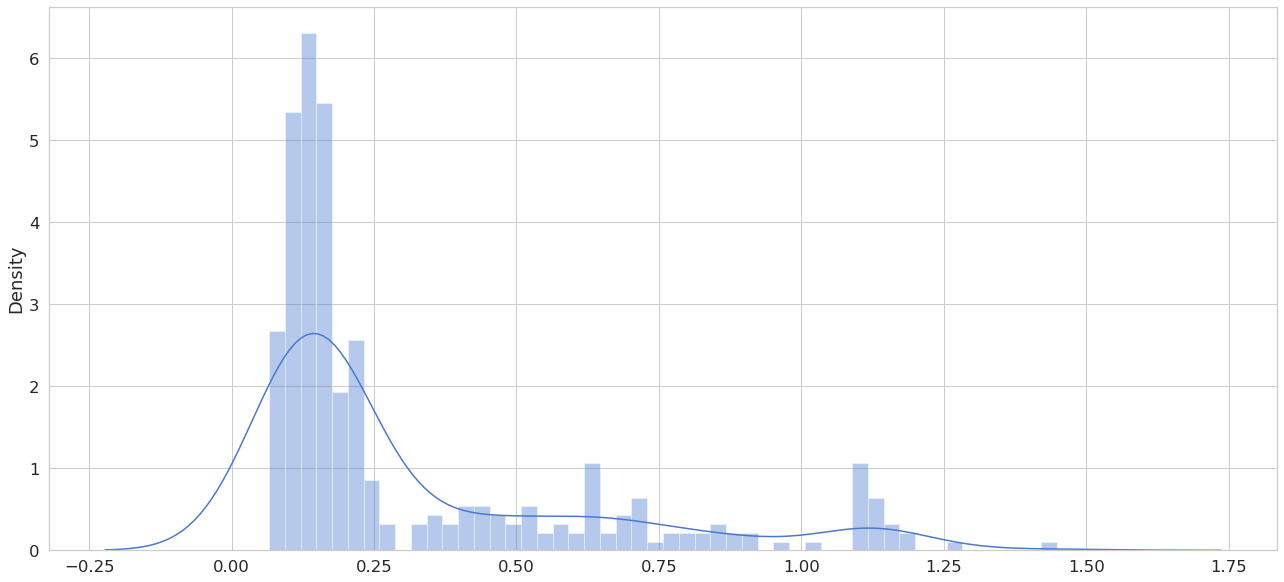

In [125]:
data = sns.distplot(anomalyEnc.train_mae_loss, bins=50, kde=True).get_lines()[0].get_data()
#data[0][25], data[1][25]

In [ ]:
#anomalyEnc.train_mae_loss

In [126]:
#threshold_X = data[0][25]
threshold_X = 0.4
anomalyEnc.evaluateAnomalies(threshold_X)

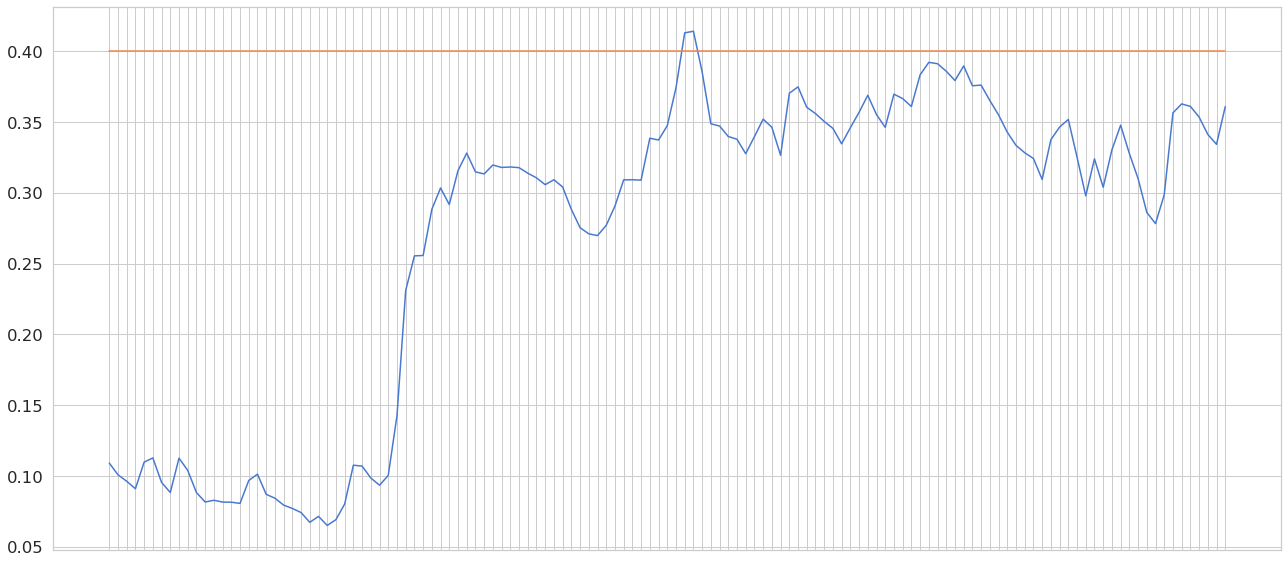

In [127]:
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 

plt.plot(anomalyEnc.test_score_df.index, anomalyEnc.test_score_df.loss, label='loss')
plt.plot(anomalyEnc.test_score_df.index, anomalyEnc.test_score_df.threshold, label='threshold')
#plt.xticks(rotation=25)
#plt.legend();

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


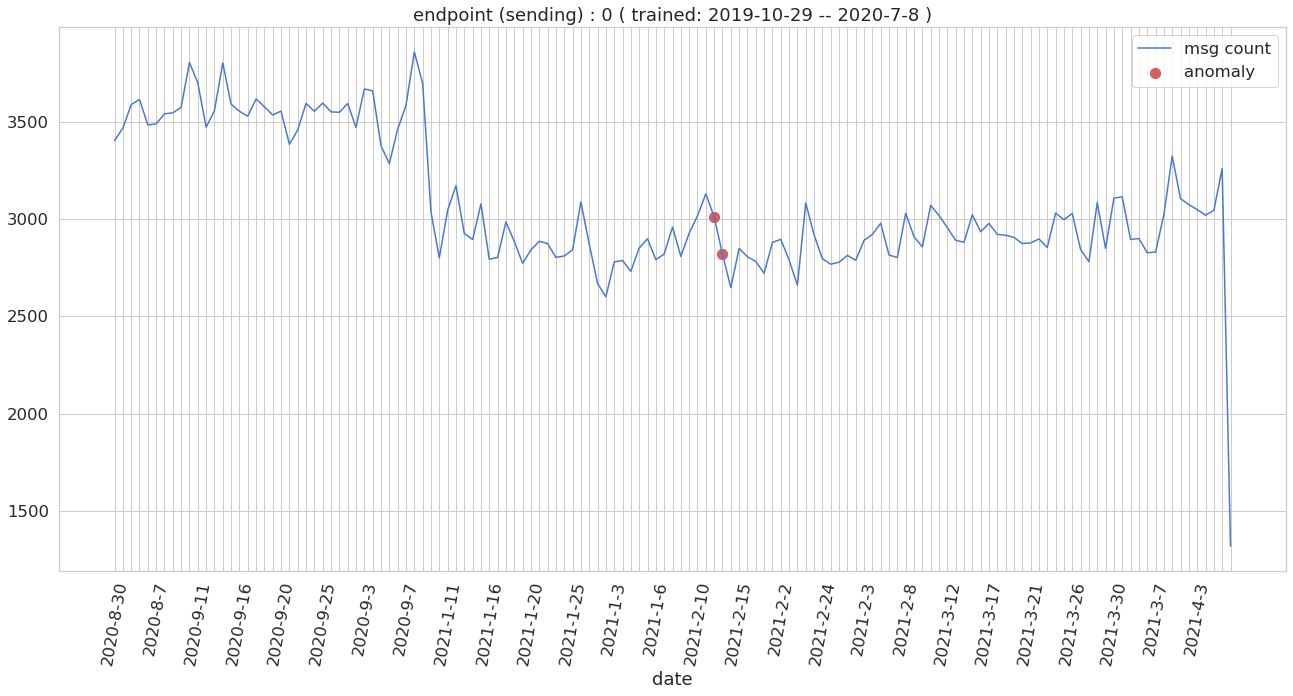

In [128]:
sender = 0
titlestring ="endpoint (sending) : " + str(sender) + " ( trained: " +  anomalyEnc.train.index[0] + " -- " + anomalyEnc.train.index[len(anomalyEnc.train.index)-1] + " )"
anomaly.plot_test(anomalyEnc.test,anomalyEnc.scaler,anomalyEnc.anomalies,titlestring)

In [29]:
anomalyEnc.anomalies.index

Index(['2021-3-12', '2021-3-13', '2021-3-14'], dtype='object', name='date')

In [20]:
pda[pda['date'] == anomalyEnc.anomalies.iloc[0].name]
#pfall1.head()
#pfall1
#pda
#pda['date'] == anomalyEnc.anomalies.iloc[0].name

,date,year,month,day,outcome
499,2021-3-11,2021,3,11,63299


In [32]:
anomalyEnc.test[100:]

,close
date,
2021-2-8,0.627599
2021-2-9,0.751216
2021-2-10,1.196174
2021-2-11,0.531103
2021-2-12,1.054456
2021-2-13,-0.763278
2021-2-14,-1.040001
2021-2-15,0.392467
2021-2-16,0.848592


In [19]:
anomalyEnc.anomalies.iloc[0].name, pda['date'][0]

('2021-3-11', '2019-10-29')

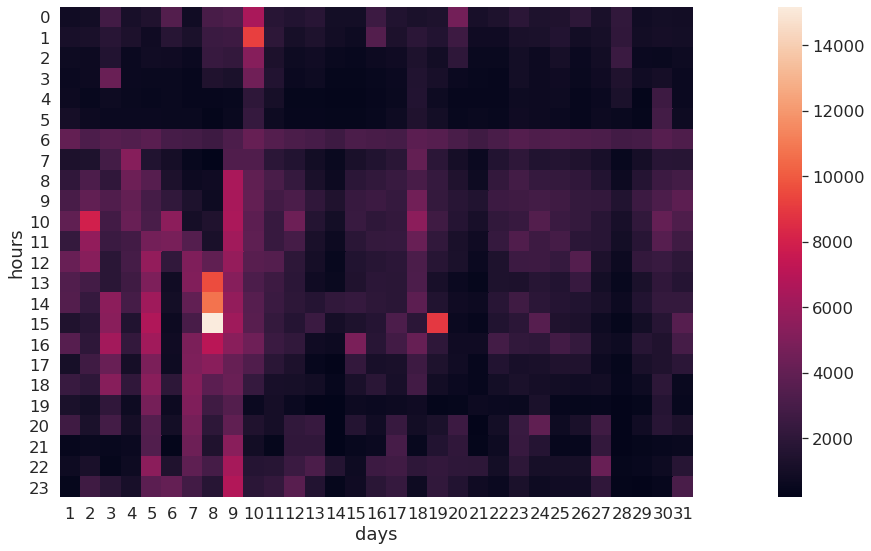

<AxesSubplot:xlabel='days', ylabel='hours'>

In [27]:
data2 = createData(pfall,3)
piv = pd.pivot_table(data2, values="outcome",index=["hours"], columns=["days"], fill_value=0)
createHeatmap(piv, '')